## Hippocampal Place field KDE estimation

A tyipcal hippocampal neuron fire when the animal travels in a particular place in an environment, such as a track field, we call this particular place a place field, or here in our inference setting, a place parameter $\theta$ determining the neuron firing. 

This statistical [package](https://elifesciences.org/articles/64505) uses kernel density estimator for estimating the place parameter for each hippocampal neuron.

We formulate the problem is given the observations -- the neuron's spiking rate at a particular location $y$ -- to infer the place parameter $\theta$. Constructing $P(\theta | {y}_1^n)$ by KDE is equivalent to Bayesian inferencing using a uniform prior and a normal likelihood.

### 1. Generate data

In [1]:
### we get animal data from our lab database
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.shijiegu.decodeHelpers import runSessionNames
import numpy as np
from spyglass.shijiegu.singleUnit import session_unit, find_spikes, electrode_unit

[2025-04-29 09:24:58,352][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [2]:
nwb_copy_file_name = "lewis20240109_.nwb"
session_interval, position_interval = runSessionNames(nwb_copy_file_name)

e = 1
session_name = session_interval[e]
position_name = position_interval[e]
linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_name,
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[09:25:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.704833e+09,NaN,0,NaN,NaN
1.704833e+09,NaN,0,NaN,NaN
1.704833e+09,NaN,0,NaN,NaN
1.704833e+09,NaN,0,NaN,NaN
1.704833e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.704835e+09,580.361520,8,256.641658,62.349715
1.704835e+09,580.369542,8,256.644803,62.342336
1.704835e+09,580.377564,8,256.647949,62.334957


In [3]:
### find intervals animal is in arm 3
linear_position_df = linear_position_df[np.logical_and(linear_position_df.linear_position >= 500, linear_position_df.linear_position <= 600)]

Text(0, 0.5, 'animal position')

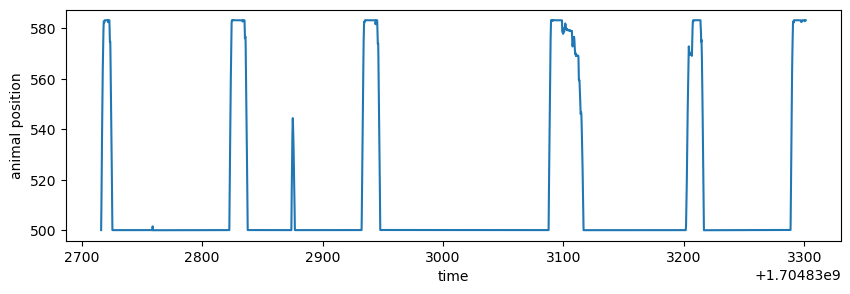

In [4]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize = (10,3),sharex = True)
ind = np.arange(50000)
t = np.array(linear_position_df.index)[ind]
pos = np.array(linear_position_df.linear_position)[ind]
axes.plot(t, pos)
plt.xlabel("time")
plt.ylabel("animal position")

In [5]:
nwb_units = electrode_unit(nwb_copy_file_name,session_name,
                   15,
                   curation_id = 1)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
nwb_units_all = {}
nwb_units_all[15] = nwb_units
intvl = t
binned_spike_count, time_bin = find_spikes(nwb_units_all,[(15,11)], #(15,19),(15,21),(15,23),(15,25)
                                           intvl,count = True)
binned_spike_count = binned_spike_count > 0
binned_spike_count = binned_spike_count.ravel()

Text(0, 0.5, 'spike (binary)')

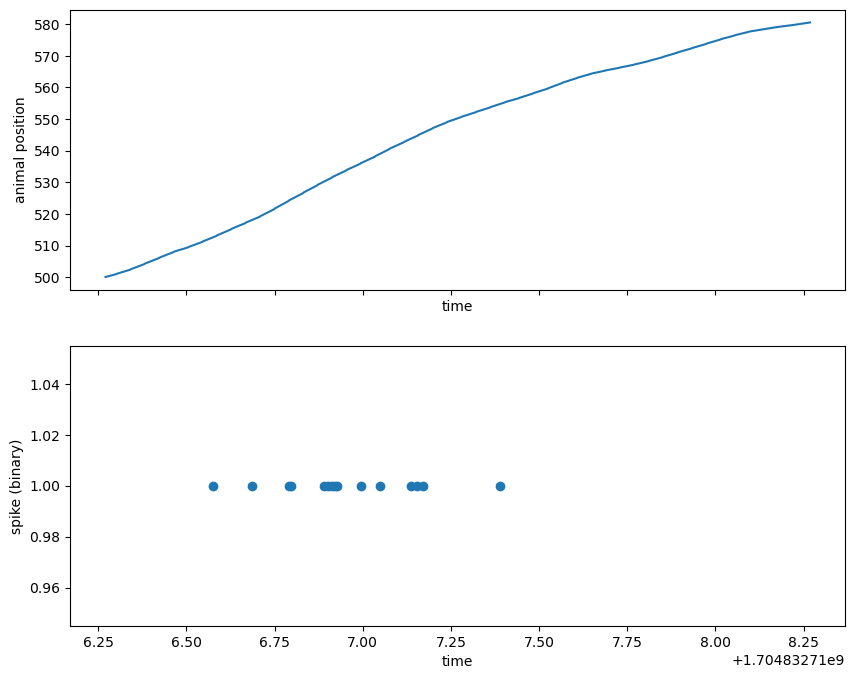

In [7]:
fig,axes = plt.subplots(2,1,figsize = (10,8),sharex = True)

ind_plot = np.arange(1000)
axes[0].plot(t[ind_plot], pos[ind_plot])
axes[0].set_xlabel("time")
axes[0].set_ylabel("animal position")

binned_spike_count_plot = binned_spike_count[ind_plot]
time_bin_plot = time_bin[ind_plot]
axes[1].scatter(time_bin_plot[binned_spike_count_plot > 0], binned_spike_count_plot[binned_spike_count_plot > 0])
axes[1].set_xlabel("time")
axes[1].set_ylabel("spike (binary)")

### 2. inferencing with uniform prior and normal likelihood, or equivalently KDE

In [8]:
from replay_trajectory_classification.likelihoods import spiking_likelihood_kde

In [9]:
len(binned_spike_count)

49999

In [10]:
pos_min = np.min(pos)
pos_max = np.max(pos)
pos_binsize = 5 #cm
place_bin_centers = np.arange(pos_min,pos_max,pos_binsize)

In [18]:
binned_spike_count

array([False, False, False, ..., False, False, False])

In [23]:
conditional_intensity_1 = spiking_likelihood_kde.estimate_place_fields_kde(
    pos[:-1],
    binned_spike_count,
    place_bin_centers,
    is_track_interior = np.ones(len(place_bin_centers))>0,
    position_std = 1).mean(axis = 1)

conditional_intensity_5 = spiking_likelihood_kde.estimate_place_fields_kde(
    pos[:-1],
    binned_spike_count,
    place_bin_centers,
    is_track_interior = np.ones(len(place_bin_centers))>0,
    position_std = 5).mean(axis = 1)

conditional_intensity_15 = spiking_likelihood_kde.estimate_place_fields_kde(
    pos[:-1],
    binned_spike_count,
    place_bin_centers,
    is_track_interior = np.ones(len(place_bin_centers))>0,
    position_std = 15).max(axis = 1)

Text(0, 0.5, 'probability of a spike')

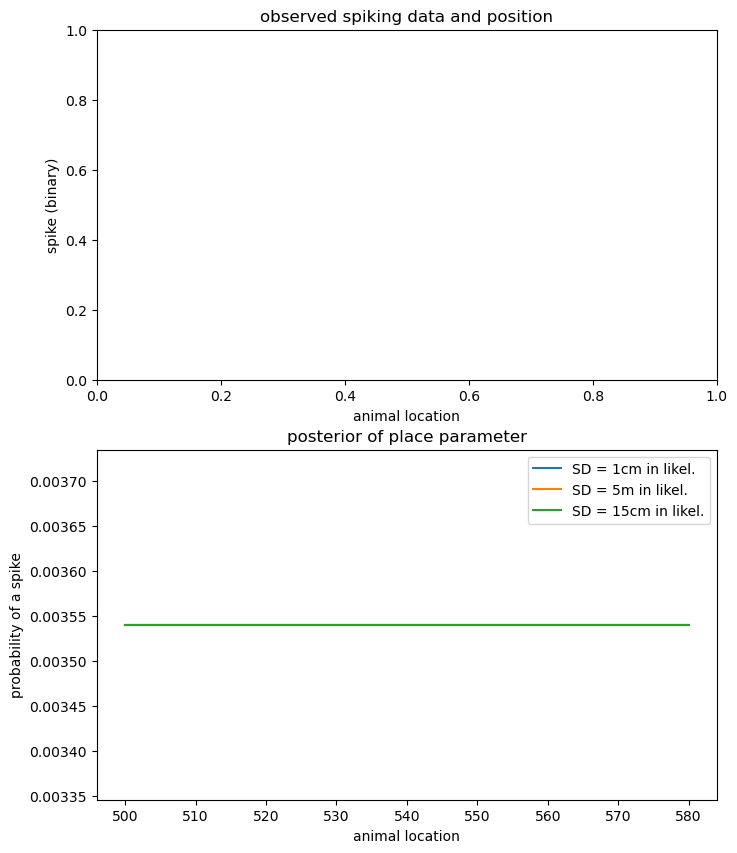

In [25]:
fig,axes = plt.subplots(2,1,figsize = (8,10),sharex = False)

#axes[0].plot(pos[:-1], binned_spike_count)
axes[0].set_xlabel("animal location")
axes[0].set_ylabel("spike (binary)")
axes[0].set_title("observed spiking data and position")

axes[1].plot(place_bin_centers,conditional_intensity_1, label = "SD = 1cm in likel.")
axes[1].plot(place_bin_centers,conditional_intensity_5, label = "SD = 5m in likel.")
axes[1].plot(place_bin_centers,conditional_intensity_15, label = "SD = 15cm in likel.")
axes[1].legend()
axes[1].set_title("posterior of place parameter")
axes[1].set_xlabel("animal location")
axes[1].set_ylabel("probability of a spike")

### 3. posterior predictive data

In [ ]:
from scipy.stats import bernoulli

# Probability of success (e.g., probability of getting heads in a coin toss)
p = 0.6

# Generate a single random sample from the Bernoulli distribution
random_sample = bernoulli.rvs(p)

In [113]:
def find_posterior_predictive_data_1_trial(conditional_intensity, t, pos):
    spiking_pp = []
    for t_ind in range(len(t)):
        pos_bin = pos[t_ind]
        p_bin = np.array(conditional_intensity.sel(position = pos_bin,method='nearest'))[0]
        spiking_pp.append(bernoulli.rvs(p_bin))
    return spiking_pp

def find_posterior_predictive_data(conditional_intensity, t, pos):
    spiking_pp_all = []
    for n in range(10):
        spiking_pp_all.append(find_posterior_predictive_data_1_trial(conditional_intensity, t, pos))
    return spiking_pp_all

In [114]:
spiking_pp_all = find_posterior_predictive_data(conditional_intensity_1, t, pos)

In [147]:
spiking_pp_all_5 = find_posterior_predictive_data(conditional_intensity_5, t, pos)
spiking_pp_all_15 = find_posterior_predictive_data(conditional_intensity_15, t, pos)

Text(0, 0.5, 'probability of a spike')

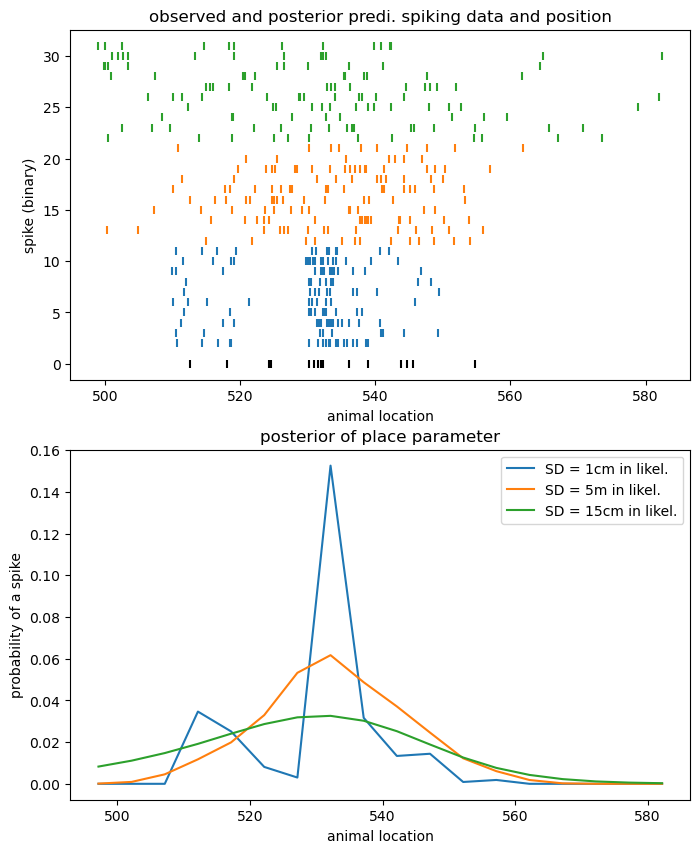

In [148]:
fig,axes = plt.subplots(2,1,figsize = (8,10),sharex = False)

obs = binned_spike_count.reshape((1,-1))[0].ravel()
pos_plot = pos[:-1]
axes[0].scatter(pos_plot[obs > 0], obs[obs > 0] - 1, marker = "|", color = "k")
row_ind = 1
for spiking_pp in spiking_pp_all:
    obs = np.array(spiking_pp[:-1])
    axes[0].scatter(pos_plot[obs > 0], obs[obs > 0]  + row_ind, marker = "|", color = "C0")
    row_ind = row_ind + 1

for spiking_pp in spiking_pp_all_5:
    obs = np.array(spiking_pp[:-1])
    axes[0].scatter(pos_plot[obs > 0], obs[obs > 0]  + row_ind, marker = "|", color = "C1")
    row_ind = row_ind + 1

for spiking_pp in spiking_pp_all_15:
    obs = np.array(spiking_pp[:-1])
    axes[0].scatter(pos_plot[obs > 0], obs[obs > 0]  + row_ind, marker = "|", color = "C2")
    row_ind = row_ind + 1
axes[0].set_xlabel("animal location")
axes[0].set_ylabel("spike (binary)")
axes[0].set_title("observed and posterior predi. spiking data and position")

axes[1].plot(place_bin_centers,conditional_intensity_1, label = "SD = 1cm in likel.")
axes[1].plot(place_bin_centers,conditional_intensity_5, label = "SD = 5m in likel.")
axes[1].plot(place_bin_centers,conditional_intensity_15, label = "SD = 15cm in likel.")
axes[1].legend()
axes[1].set_title("posterior of place parameter")
axes[1].set_xlabel("animal location")
axes[1].set_ylabel("probability of a spike")

### As we increase the likelihood normal distribution kernel size, the data generated from the posterior predictive distribution becomes broader in the spatial domain (green spikes in the top panel), compared to the real data (black spikes in the top panel). Even 5cm SD model deviates a lot from the data, suggesting the inference is sensitive to the likelihood model. 